# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">Sentiment Analysis Locally</div>

In [1]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import re
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import nltk
import ast
pd.set_option('display.max_colwidth', 1000)

# Load News Data
## Config

In [2]:
start_date = "2024-01-01"
end_date = "2024-08-30"
folder_path = r"data/fx/"
tag = "GBPUSD"
aspect = "GBP"

In [3]:
# Concatenate all DataFrames from the folder
df = pd.read_excel(folder_path+tag+'_q2'+'.xlsx')
#drop empty data and some columns
df = df.dropna(subset=['Title'])

#Set date as index and sort df base on date
df.set_index('Created Date', inplace=True)
df.index = pd.to_datetime('2024 ' + df.index, format='%Y %b %d, %H:%M %Z')
df = df.sort_index()

# Filter the DataFrame based on the time period
df = df.loc[start_date:end_date]
df

,Title,Tag
Created Date,,
2024-04-29 01:49:00+00:00,"GBP/USD holds positive ground above 1.2500 on weaker US Dollar, Fed rate decision looms",GBPUSD
2024-04-29 14:44:00+00:00,"GBP/USD Price Analysis: Climbs above 1.2500, with bulls targeting 200-DMA",GBPUSD
2024-04-29 23:04:00+00:00,"GBP/USD consolidates its gains above 1.2550, investors await Fed rate decision",GBPUSD
2024-04-30 14:57:00+00:00,"GBP/USD Price Analysis: Drops below 200-DMA, at cross-roads to resume downtrend",GBPUSD
2024-04-30 23:19:00+00:00,GBP/USD holds below 1.2500 ahead of Fed rate decision,GBPUSD
...,...,...
2024-08-26 10:37:00+00:00,GBP/USD: There is room for GBP to test 1.3250 – UOB Group,GBPUSD
2024-08-26 13:40:00+00:00,GBP/USD: Little changed on the day – Scotiabank,GBPUSD
2024-08-26 14:53:00+00:00,GBP/USD Price Forecast: Clings to 1.3200 in sideways trading,GBPUSD


# Get Sentiment Score
## 1. FinBert

In [4]:
# 初始化 FinBERT 模型
#model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained("models/finbert/tokenizer")
model = AutoModelForSequenceClassification.from_pretrained("models/finbert/model",num_labels=3)
finbert_model = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def compute_finbert_sentiment(text):
    try:
        chunks = nltk.sent_tokenize(text)
        if len(chunks) == 1:
            result = finbert_model(text)
            label = result[0]['label']
            score = result[0]['score']
            if label == 'Positive':
                return score
            elif label == 'Neutral':
                return 0.0
            elif label == 'Negative':
                return -1.0*score
        else:
            sentiments = []
            for chunk in chunks:
                result = finbert_model(chunk)
                label = result[0]['label']
                score = result[0]['score']
                if label == 'Positive':
                    sentiments.append(score)
                elif label == 'Neutral':
                    sentiments.append(0)
                elif label == 'Negative':
                    sentiments.append(-1*score)
            score = sum(sentiments) / len(sentiments)
            if score > 0:
                positive_values = [val for val in sentiments if val > 0]
                return  sum(positive_values) / len(positive_values)
            elif score < 0:
                negative_values = [val for val in sentiments if val < 0]
                return sum(negative_values) / len(negative_values)
            else:
                return 0.0
    except Exception as e:
        print(f"Error processing text: {e}")
        return np.nan

In [5]:
%%time
df['FinBERT_sentiment_title'] = df['Title'].apply(compute_finbert_sentiment)
df[df['FinBERT_sentiment_title']!=0]

CPU times: user 35.2 s, sys: 27.3 s, total: 1min 2s
Wall time: 17.8 s


,Title,Tag,FinBERT_sentiment_title
Created Date,,,
2024-04-29 01:49:00+00:00,"GBP/USD holds positive ground above 1.2500 on weaker US Dollar, Fed rate decision looms",GBPUSD,0.999524
2024-04-30 14:57:00+00:00,"GBP/USD Price Analysis: Drops below 200-DMA, at cross-roads to resume downtrend",GBPUSD,-0.959249
2024-05-01 23:12:00+00:00,"GBP/USD gains traction above 1.2500, Fed keeps rates steady",GBPUSD,1.000000
2024-05-02 06:17:00+00:00,GBP/USD Price Analysis: Advances to near 1.2550 with expectations of a momentum shift,GBPUSD,0.972760
2024-05-08 14:39:00+00:00,"GBP/USD Price Analysis: Downtrend remains, despite bouncing off the daily low",GBPUSD,-0.992466
...,...,...,...
2024-08-22 16:46:00+00:00,"GBP/USD Price Forecast: Clings to gains, struggles near 1.3100",GBPUSD,-0.999874
2024-08-22 22:41:00+00:00,"GBP/USD rally grinds to a halt, but downside remains limited",GBPUSD,-0.996819
2024-08-23 16:20:00+00:00,"GBP/USD hits multi-year high post Powell dovish pivot, rose above 1.3200",GBPUSD,0.999859


## 2. ABSA_Bert Model
Github: https://github.com/yangheng95/PyABSA
Hugging face: https://huggingface.co/yangheng/deberta-v3-base-absa-v1.1

In [6]:
# Load the ABSA model and tokenizer
#model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained("models/absa/tokenizer", use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained("models/absa/model")
absa_model = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [7]:
def compute_absa_sentiment(text, aspect):
    try:
        chunks = nltk.sent_tokenize(text)
        if len(chunks) == 1:
            result = absa_model(text, text_pair=aspect)
            label = result[0]['label']
            score = result[0]['score']
            if label == 'Positive':
                return score
            elif label == 'Neutral':
                return 0.0
            elif label == 'Negative':
                return -1.0*score
        else:
            sentiments = []
            for chunk in chunks:
                result = absa_model(chunk, text_pair=aspect)
                label = result[0]['label']
                score = result[0]['score']
                if label == 'Positive':
                    sentiments.append(score)
                elif label == 'Neutral':
                    sentiments.append(0)
                elif label == 'Negative':
                    sentiments.append(-1*score)
            score = sum(sentiments) / len(sentiments)
            if score > 0:
                positive_values = [val for val in sentiments if val > 0]
                return  sum(positive_values) / len(positive_values)
            elif score < 0:
                negative_values = [val for val in sentiments if val < 0]
                return sum(negative_values) / len(negative_values)
            else:
                return 0.0
    except Exception as e:
        print(f"Error processing text: {e}")
    return 0.0

In [8]:
%%time
df[f'ABSA_Bert_sentiment_title_{aspect}'] = df['Title'].apply(lambda x: compute_absa_sentiment(x, aspect))
df[df[f'ABSA_Bert_sentiment_title_{aspect}']!=0]

CPU times: user 54.8 s, sys: 42.6 s, total: 1min 37s
Wall time: 27.6 s


,Title,Tag,FinBERT_sentiment_title,ABSA_Bert_sentiment_title_GBP
Created Date,,,,
2024-04-29 01:49:00+00:00,"GBP/USD holds positive ground above 1.2500 on weaker US Dollar, Fed rate decision looms",GBPUSD,0.999524,0.812491
2024-05-02 14:57:00+00:00,GBP/USD Price Analysis: Tumbles below crucial 1.2500 as bears move in,GBPUSD,0.000000,-0.649444
2024-05-02 23:06:00+00:00,"GBP/USD trades on a stronger note 1.2530, all eyes on US NFP data",GBPUSD,0.000000,0.767296
2024-05-06 05:25:00+00:00,GBP/USD rises to near 1.2550 due to dovish sentiment surrounding Fed,GBPUSD,0.000000,0.823240
2024-05-06 23:24:00+00:00,"GBP/USD extends the rally above 1.2550, eyes on BoE rate decision",GBPUSD,0.000000,0.508818
2024-05-09 05:24:00+00:00,GBP/USD moves below 1.2500 ahead of BoE policy decision,GBPUSD,0.000000,-0.587709
2024-05-15 23:15:00+00:00,GBP/USD extends its upside above 1.2680 on weaker US Dollar,GBPUSD,0.999998,0.930117
2024-05-20 04:23:00+00:00,GBP/USD advances to near 1.2700 due to rising expectations for Fed rate cuts in 2024,GBPUSD,0.000000,0.742416
2024-05-22 14:57:00+00:00,GBP/USD Price Analysis: Stays bullish despite retreating from two-month highs,GBPUSD,0.999983,0.676129


## VaderSentiment

In [9]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to compute sentiment score
def compute_sentiment(text):
    try:
        sentiment = analyzer.polarity_scores(text)
        # Return the compound score which is a normalized score between -1 and 1
        return sentiment['compound']  
    except:
        return 0.0
# Apply the sentiment function to the 'title' and 'content' columns
df['Vader_sentiment_title'] = df['Title'].apply(compute_sentiment)
df[df['Vader_sentiment_title']!=0]

,Title,Tag,FinBERT_sentiment_title,ABSA_Bert_sentiment_title_GBP,Vader_sentiment_title
Created Date,,,,,
2024-04-29 01:49:00+00:00,"GBP/USD holds positive ground above 1.2500 on weaker US Dollar, Fed rate decision looms",GBPUSD,0.999524,0.812491,0.0258
2024-04-29 23:04:00+00:00,"GBP/USD consolidates its gains above 1.2550, investors await Fed rate decision",GBPUSD,0.000000,0.000000,0.4215
2024-05-01 14:33:00+00:00,GBP/USD Price Analysis: Wavers below 1.2500 as bearish harami looms,GBPUSD,0.000000,0.000000,-0.1531
2024-05-01 23:12:00+00:00,"GBP/USD gains traction above 1.2500, Fed keeps rates steady",GBPUSD,1.000000,0.000000,0.3400
2024-05-02 23:06:00+00:00,"GBP/USD trades on a stronger note 1.2530, all eyes on US NFP data",GBPUSD,0.000000,0.767296,0.3818
...,...,...,...,...,...
2024-08-22 16:46:00+00:00,"GBP/USD Price Forecast: Clings to gains, struggles near 1.3100",GBPUSD,-0.999874,0.000000,-0.0258
2024-08-22 22:41:00+00:00,"GBP/USD rally grinds to a halt, but downside remains limited",GBPUSD,-0.996819,0.000000,-0.5927
2024-08-23 05:10:00+00:00,"GBP/USD extends rally above 1.3100, focus on BoE’s Bailey and Fed’s Powell speeches",GBPUSD,0.000000,0.507574,0.1280


In [10]:
df.to_csv("result/"+tag+'_news_scores.csv')

# Word Cloud
## Data Process

In [11]:
def word_dict(df, word_source_column, score_column):  
    dict = {}
    for index, row in df.iterrows():
        words = re.findall(r'\b\w+\b', row[word_source_column])
        words = set(words)
        score = row[score_column]
        for word in words:
            if word in dict:
                dict[word].append(score)
            else:
                dict[word] = [score]
                
    for word, scores in dict.items():
        average_score = sum(scores) / len(scores)
        dict[word] = (average_score, len(scores))
    return dict
# Initialize an empty dictionary to store words as keys and list of sentiment scores as values

df_Vader = df.dropna(subset=['Vader_sentiment_title'])
df_Vader = df_Vader[df_Vader['Vader_sentiment_title']!=0]

df_ABSA_Bert = df.dropna(subset=[f'ABSA_Bert_sentiment_title_{aspect}'])
df_ABSA_Bert = df_ABSA_Bert[df_ABSA_Bert[f'ABSA_Bert_sentiment_title_{aspect}']!=0]

df_FinBert = df.dropna(subset=['FinBERT_sentiment_title'])
df_FinBert = df_FinBert[df_FinBert['FinBERT_sentiment_title']!=0]

vader_title_word_dict = word_dict(df_Vader, "Title", "Vader_sentiment_title")
absa_title_word_dict = word_dict(df_ABSA_Bert, "Title", f'ABSA_Bert_sentiment_title_{aspect}')
finbert_title_word_dict = word_dict(df_FinBert,"Title","FinBERT_sentiment_title")

In [12]:
from nltk.corpus import stopwords

# Custom stopwords to be added
custom_stopwords = ["will","would","make","made","making","word","take","took","taking","say","says","said","used","use","uses","user","users","using","give","gave","gives","giving",
                    "many","much","company", "companies","come","came","comes","knows","know","knew","known","also","might","whether","see","without","around",
                    "can","could","even","still","help","helps","helped","look","looks","looked","looking","lot"
                    "first","second","third","percent","re","likely","unlikely","city","Plus","one","discusses","search",
                    "day","days""week","weeks","year","years","january","feburary","march","april","may","june","july","august","september","october","november","december"
                    "a", "b", "c", "d", "e", "f", "g", "h", "i","j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]

def remove_stopwords(word_score_dict, custom_stopwords=None):
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    
    cleaned_text_dict = {}
    
    for word, (score, freq) in word_score_dict.items():
        if word.lower() not in stop_words and not any(char.isdigit() for char in word):
            cleaned_text_dict[word] = (score, freq)
    
    return cleaned_text_dict

vader_title_word_dict = remove_stopwords(vader_title_word_dict, custom_stopwords)
absa_title_word_dict = remove_stopwords(absa_title_word_dict, custom_stopwords)
finbert_title_word_dict = remove_stopwords(finbert_title_word_dict, custom_stopwords)

In [13]:
def keep_top_n_words(word_score_dict, n):
    top_words = dict(sorted(word_score_dict.items(), key=lambda x: x[1][1], reverse=True)[:n])
    return top_words

# Keep only the top 50 words based on scores
vader_title_word_dict = keep_top_n_words(vader_title_word_dict, 50)
absa_title_word_dict = keep_top_n_words(absa_title_word_dict, 50)
finbert_title_word_dict = keep_top_n_words(finbert_title_word_dict, 50)

In [14]:
# Custom colormap from green to grey to red
custom_cmap = mcolors.LinearSegmentedColormap.from_list('green_grey_red', ['red', 'lightgrey', 'green'])

# Function to map scaled score to color
def score_to_color(score):
    # Normalize the score to be between 0 and 1
    normalized_score = (score + 1) / 2
    # Map the normalized score to a color from green to red
    return mcolors.to_hex(custom_cmap(normalized_score))

## 1. Vader Title Wordcloud

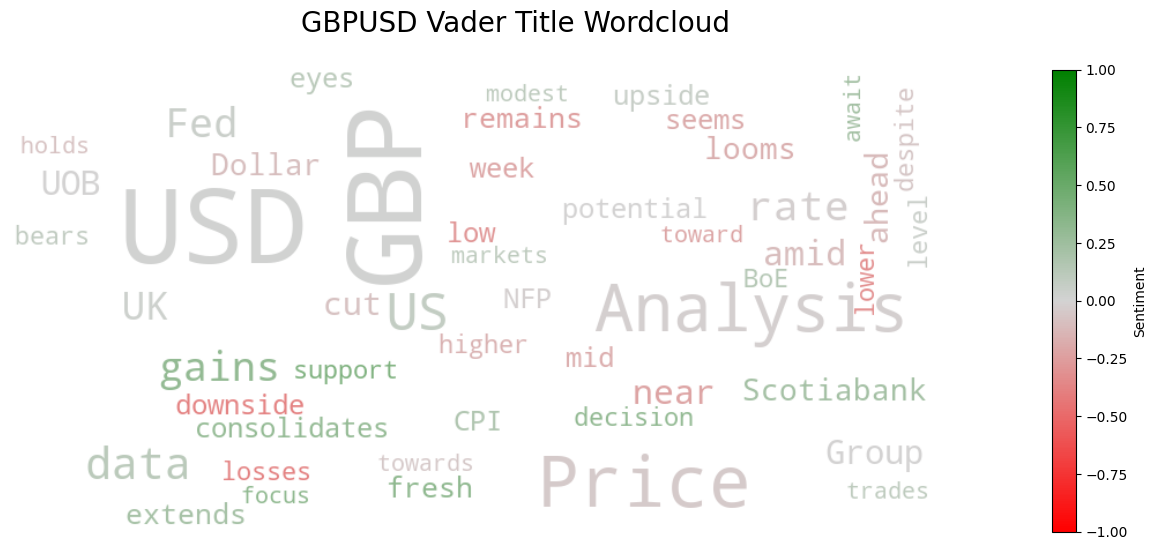

In [15]:
# Generate word cloud based on the count of scores
wordcloud = WordCloud(width=800, height=400, max_font_size=90, min_font_size=20, background_color='white').generate_from_frequencies(
    {word: count for word, (_, count) in vader_title_word_dict.items()}
)
# Color the words based on scaled average score
wordcloud.recolor(color_func=lambda word, font_size, position, orientation, random_state=None, **kwargs:
                  score_to_color(vader_title_word_dict[word][0]))

# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [40, 1]})

plt.suptitle(f'{tag} Vader Title Wordcloud', fontsize=20)

# Plot the word cloud
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].axis('off')

# Add a color bar to the second subplot
sm = plt.cm.ScalarMappable(cmap=custom_cmap,norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, cax=axs[1])
cbar.set_label('Sentiment')
plt.savefig(f'result/{tag} Vader Title Wordcloud.png')
plt.show()

## 2. Absa Title Wordcloud

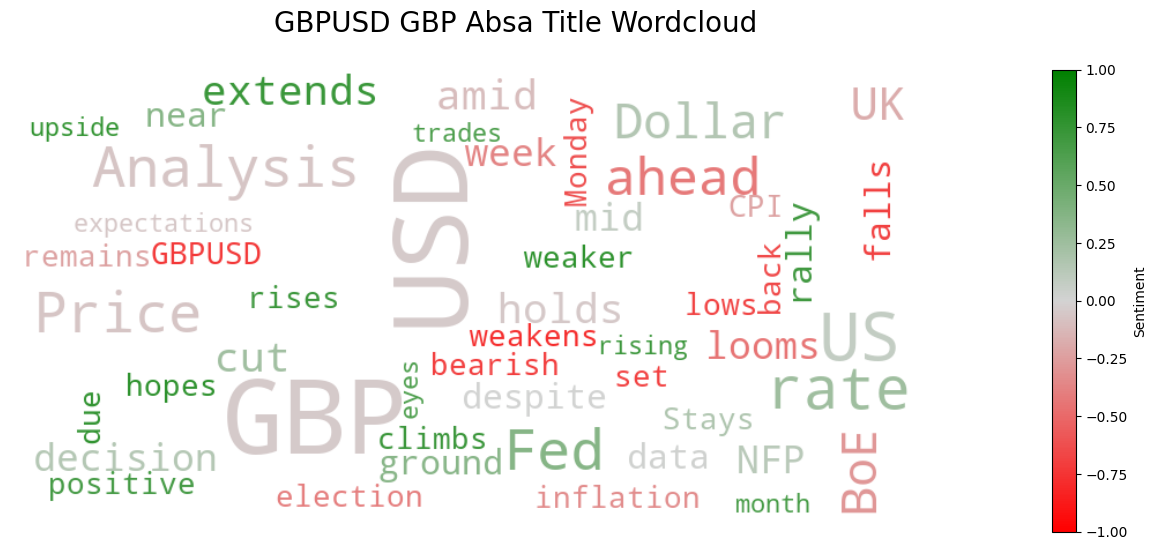

In [16]:
# Generate word cloud based on the count of scores
wordcloud = WordCloud(width=800, height=400, max_font_size=90, min_font_size=20, background_color='white').generate_from_frequencies(
    {word: count for word, (_, count) in absa_title_word_dict.items()}
)
# Color the words based on scaled average score
wordcloud.recolor(color_func=lambda word, font_size, position, orientation, random_state=None, **kwargs:
                  score_to_color(absa_title_word_dict[word][0]))

# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [40, 1]})

plt.suptitle(f'{tag} {aspect} Absa Title Wordcloud', fontsize=20)

# Plot the word cloud
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].axis('off')

# Add a color bar to the second subplot
sm = plt.cm.ScalarMappable(cmap=custom_cmap,norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, cax=axs[1])
cbar.set_label('Sentiment')
plt.savefig(f'result/{tag} {aspect} Absa Title Wordcloud.png')
plt.show()

## 3. Finbert Title Wordcloud

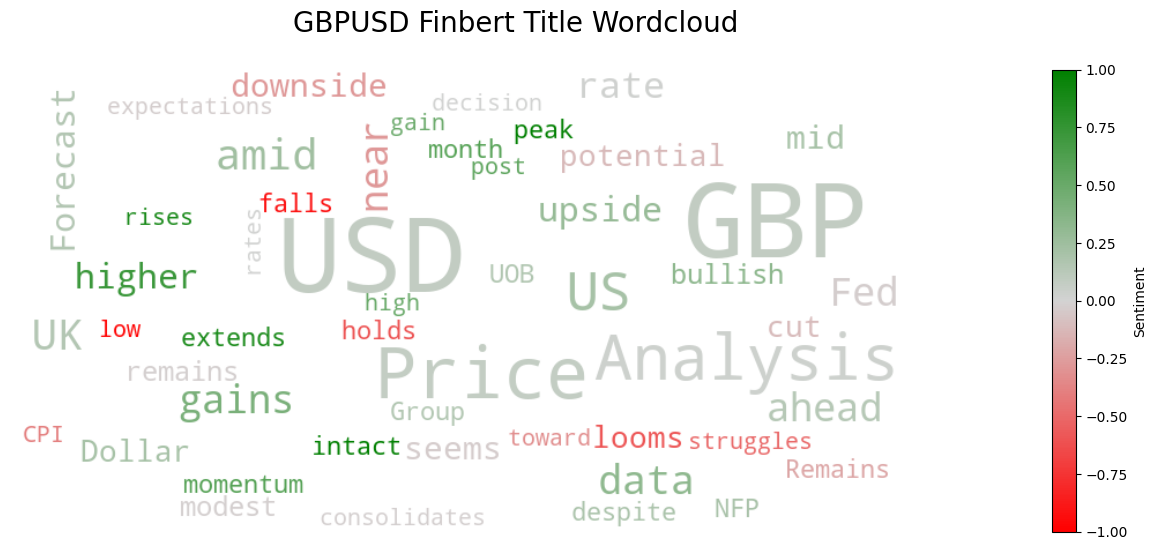

In [17]:
# Generate word cloud based on the count of scores
wordcloud = WordCloud(width=800, height=400, max_font_size=90, min_font_size=20, background_color='white').generate_from_frequencies(
    {word: count for word, (_, count) in finbert_title_word_dict.items()}
)
# Color the words based on scaled average score
wordcloud.recolor(color_func=lambda word, font_size, position, orientation, random_state=None, **kwargs:
                  score_to_color(finbert_title_word_dict[word][0]))

# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [40, 1]})

plt.suptitle(f'{tag} Finbert Title Wordcloud', fontsize=20)

# Plot the word cloud
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].axis('off')

# Add a color bar to the second subplot
sm = plt.cm.ScalarMappable(cmap=custom_cmap,norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, cax=axs[1])
cbar.set_label('Sentiment')
plt.savefig(f'result/{tag} Finbert Title Wordcloud.png')
plt.show()